<a href="https://colab.research.google.com/github/hardiksraja/TimeSeriesAnalysis_Revenue-Passenger-Miles-RPM/blob/master/Time_series_Analysis__Revenue_Passenger_Miles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series Analysis for Revenue Passenger Miles (RPM)

A revenue passenger mile (RPM) is a transportation industry metric that shows the number of miles traveled by paying passengers and is typically an airline traffic statistic. Revenue passenger miles are calculated by multiplying the number of paying passengers by the distance traveled. For example, an airplane with 100 passengers that flies 250 miles has generated 25,000 RPM.

Reference -> https://www.investopedia.com/terms/r/revenue-passenger-mile-rpm.asp

### Setup

In [7]:
from __future__ import absolute_import, division, print_function, unicode_literals
 
import seaborn as sns
import matplotlib.pyplot as plt
 
import numpy as np
from datetime import datetime
import pandas as pd
 
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (18,10)
 
from sklearn.metrics import mean_absolute_error

In [8]:
# import os, sys
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
# nb_path = '/content/notebooks'
# os.symlink('/content/mnt/My Drive/Colab Notebooks', nb_path)
# sys.path.insert(0, nb_path)  # or append(nb_path)

In [9]:
# !pip install --target=$nb_path pmdarima

In [10]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


### Data Loading and Analysis

In [11]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Advance_Stats/data/CovidCases_India_state_level_daily.csv')

In [12]:
df.head()

,Unnamed: 0,Date,State,Confirmed,Deceased,Recovered,State_Name
0,1872.0,14-Mar-20,AN,0.0,0.0,0.0,Andaman and Nicobar Islands
1,1873.0,14-Mar-20,AP,1.0,0.0,0.0,Andhra Pradesh
2,1874.0,14-Mar-20,AR,0.0,0.0,0.0,Arunachal Pradesh
3,1875.0,14-Mar-20,AS,0.0,0.0,0.0,Assam
4,1876.0,14-Mar-20,BR,0.0,0.0,0.0,Bihar


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4524 entries, 0 to 4523
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  4212 non-null   float64
 1   Date        4212 non-null   object 
 2   State       4212 non-null   object 
 3   Confirmed   4212 non-null   float64
 4   Deceased    4212 non-null   float64
 5   Recovered   4212 non-null   float64
 6   State_Name  4212 non-null   object 
dtypes: float64(4), object(3)
memory usage: 247.5+ KB


In Above, we see Period is read as an object, but as it's of date format; lets parse it into date format while reading the data.

In [14]:
def convert_to_date(date):
  return datetime.strptime(date, '%b-%y')

In [15]:
df_rpm = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Advance_Stats/data/USCarrier_Traffic_data.csv', parse_dates = ['Period'], date_parser=convert_to_date)

In [16]:
df_rpm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 242 entries, 0 to 241
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Period  242 non-null    datetime64[ns]
 1   Total   242 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 3.9 KB


With the use of Date Parser, now we see the datatype for column, *Period* is in datetime format.

 Now lets do EDA on the loaded data.

In [17]:
print('Number of Rows : ', df_rpm.shape[0])
print('Number of Columns : ', df_rpm.shape[1])
print('\nFeatures in the dataset : \n', df_rpm.columns.tolist())
print('\nMissing Values in dataset : \n', df_rpm.isnull().any())
print('\nUnique Values for various columns in dataset : \n', df_rpm.nunique())

Number of Rows :  242
Number of Columns :  2

Features in the dataset : 
 ['Period', 'Total']

Missing Values in dataset : 
 Period    False
Total     False
dtype: bool

Unique Values for various columns in dataset : 
 Period    242
Total     242
dtype: int64


In [18]:
df_rpm_non_indexed = df_rpm.copy()

Now, lets index the data, as indexing make analysis easier; In case of non- index, we need to do exact string search, but with indexing, we can do substring search over the time series data.

Also indexing, helps since lot of plots and statistical techniques require data to be indexed

In [19]:
df_rpm = df_rpm.set_index('Period')

Now lets plot the complete time series data for period January 2000 to Febuary 2020

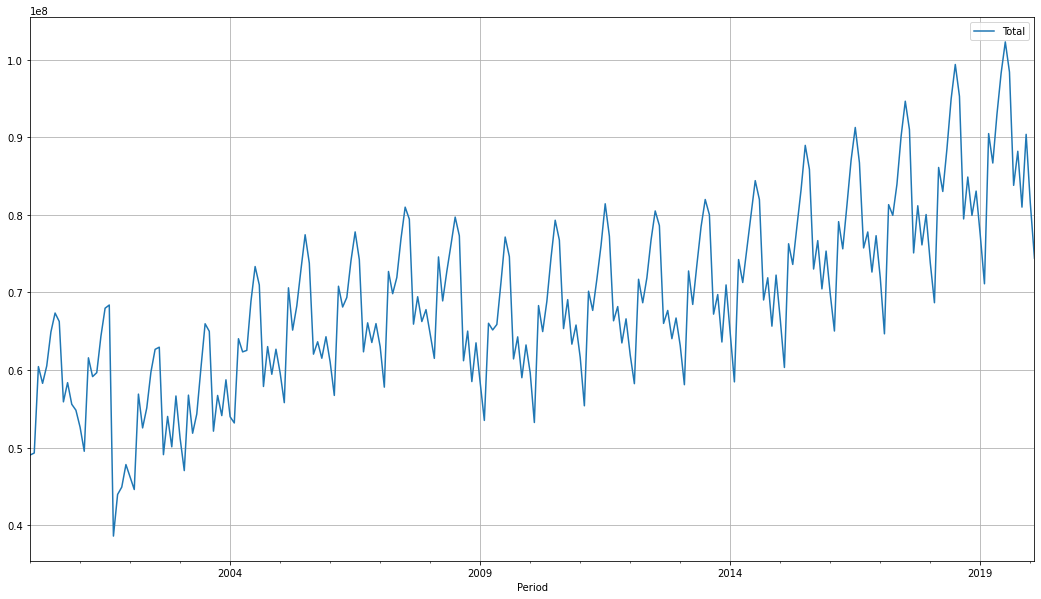

In [20]:
df_rpm.plot(grid=True)

It is clearly evident that there is an overall increasing trend in the data along with some seasonal variations.

Now, lets look both years (2010 and 2011) combined on the same plot

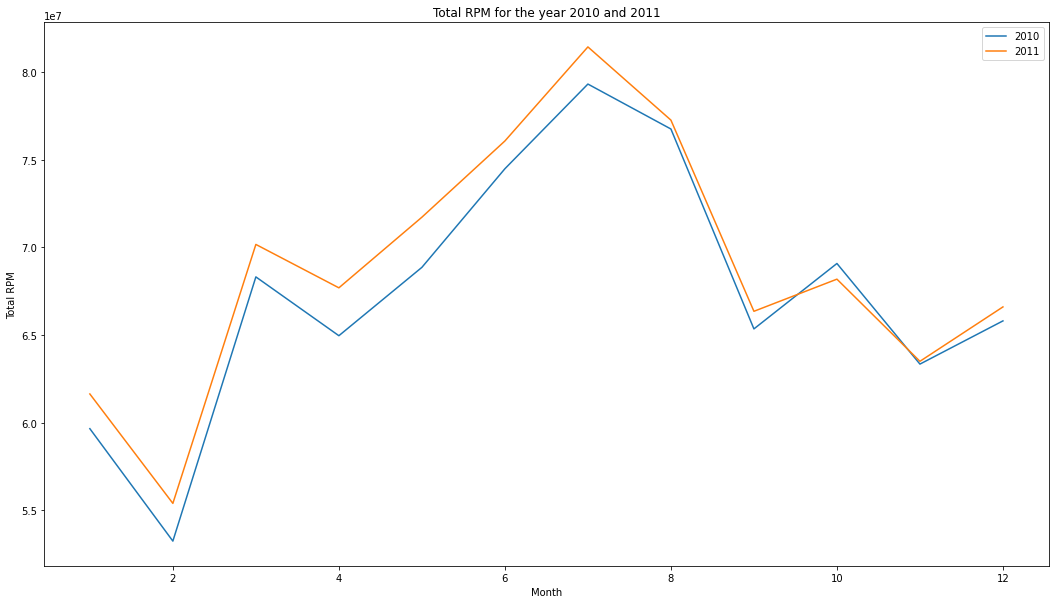

In [21]:
df_2010=df_rpm['2010'].reset_index()
df_2011=df_rpm['2011'].reset_index()

df_2010['month']= df_2011['Period'].dt.month

plt.plot(df_2010['month'],df_2010['Total'])
plt.plot(df_2010['month'],df_2011['Total'])

plt.legend(['2010','2011'])
plt.xlabel('Month')
plt.ylabel('Total RPM')
plt.title('Total RPM for the year 2010 and 2011')
plt.show()

The above plot indicates the pattern repeats across seasons.

The below plot enables, Visvualization for RPM Total with a Slider and Year window,

In [22]:
import plotly.express as px

fig = px.line(df_rpm_non_indexed, x='Period', y='Total', title='RPM Total with Slider and Year Window')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
          dict(count=1, label='1y', step='year', stepmode='backward'),
          dict(count=2, label='2y', step='year', stepmode='backward'),
          dict(count=3, label='3y', step='year', stepmode='backward'),
          dict(count=4, label='1m', step='month', stepmode='backward'),
          dict(count=5, label='2m', step='month', stepmode='backward'),
          dict(count=6, label='3m', step='month', stepmode='backward'),
          dict(step='all')
        ])
    )
)
fig.show()

Now lets plot lag plots to check correlation within the 'Total RPM' feature

It's a special type of scatter plot with X - axis having Current instance/time and Y - axis having a future instance/time with the provided lag i.e. Current time + lag period


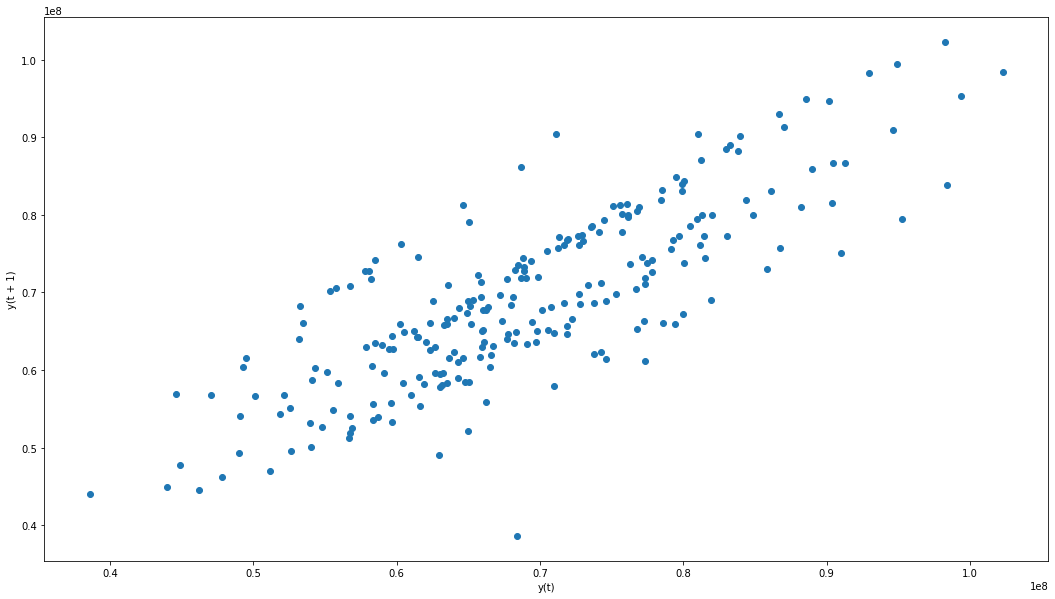

In [23]:
pd.plotting.lag_plot(df_rpm['Total'],lag=1) #1 month

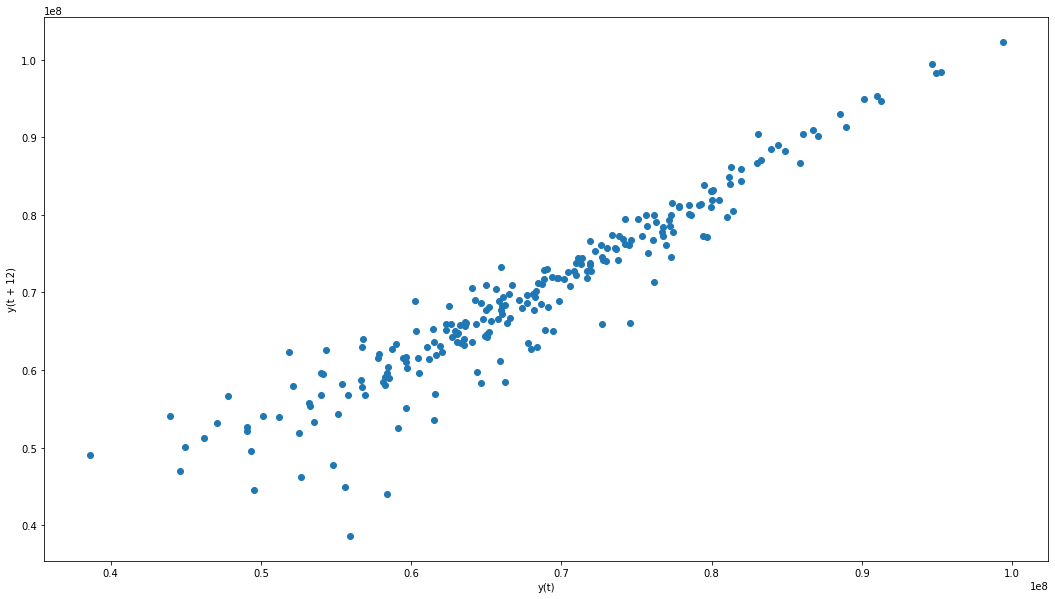

In [24]:
pd.plotting.lag_plot(df_rpm['Total'],lag=12) #1 Year

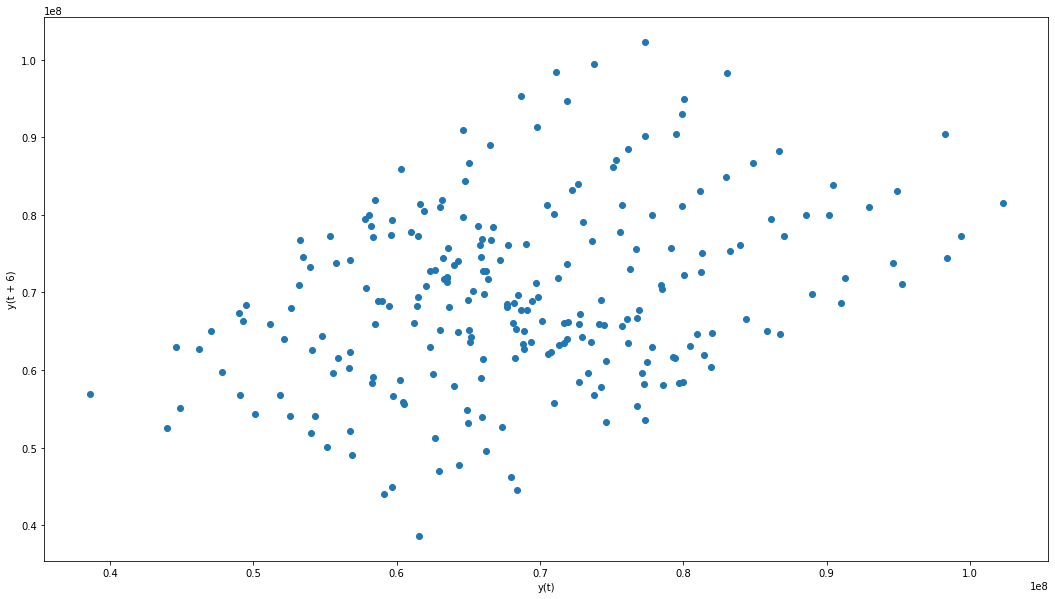

In [25]:
pd.plotting.lag_plot(df_rpm['Total'],lag=6) #6 months

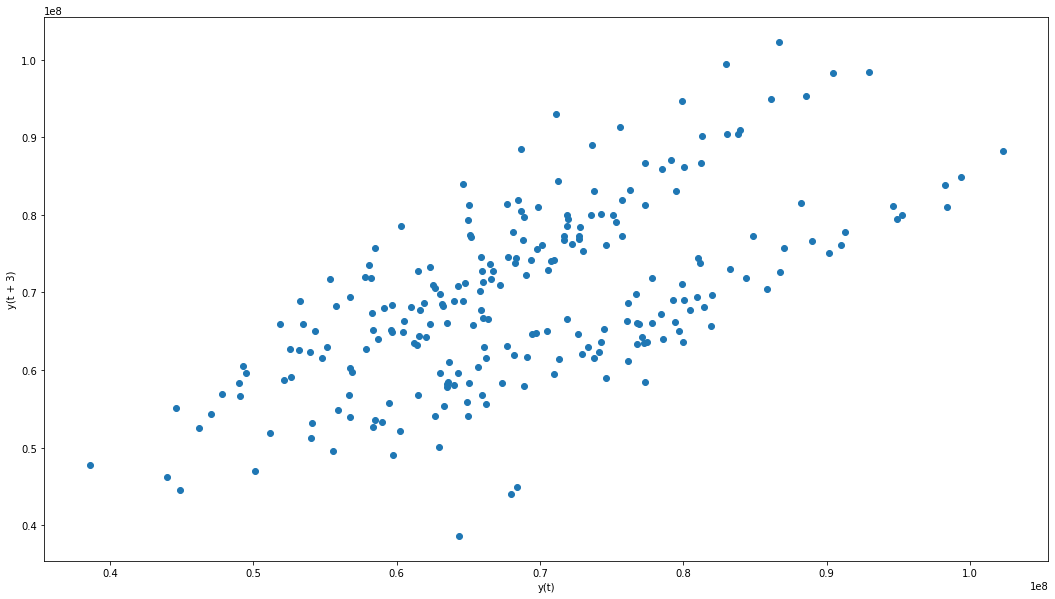

In [26]:
pd.plotting.lag_plot(df_rpm['Total'],lag=3) #3 months

In above, we plotted lag plots with Lag period as 1 month, 3 months, 6 months and 12 months.

Below are the observations at respective lags,

Lag 1 month - There is some correlation between the current and next observation

Lag 3 months and 6 months - The correlation keep on reducing as we see the data points getting more and more scattered

Lag 12 months - There is lot of linearity at lag 12 (the data points getting condensed), indicates data almost repeats after 12 months i.e a seasonal pattern

Now, lets plot an auto-coorelation plot,

Here,

> Y-axis is the lag period; In our case as its monthly data, lag is with repect to months

> X-axis is the autocorrelation value

> Strong Line 90% CI and Dotted Line 95% CI

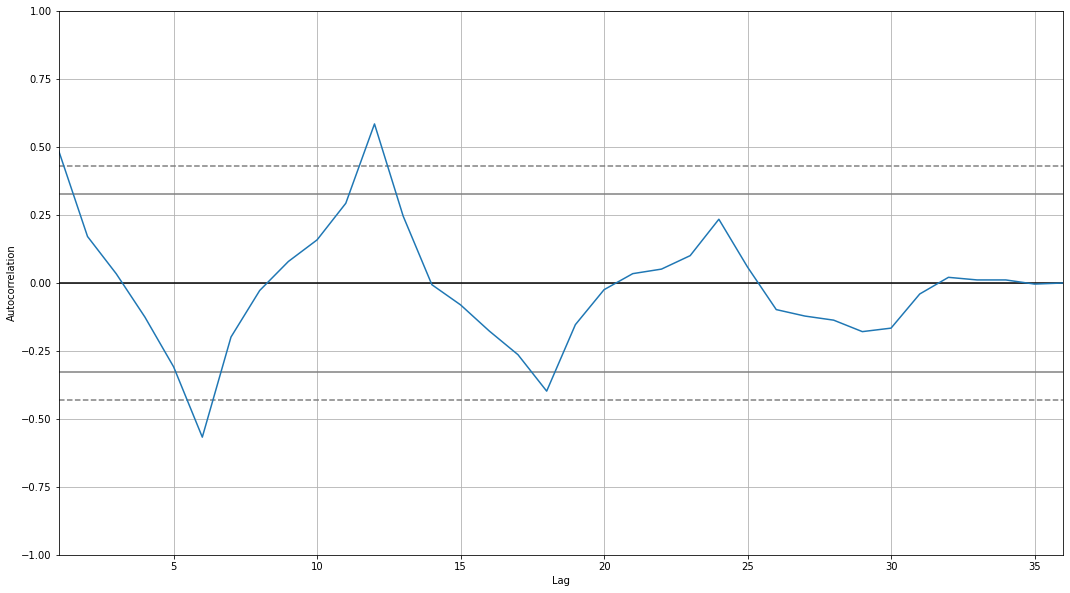

In [27]:
pd.plotting.autocorrelation_plot(df_rpm['2004':'2006']['Total'])

We notice a higher peak (meaning higher coorelation) at every 12 months and lower peak (meaning lower coorelation) at every 6 months.

## Decomposing the Time Series

Here we use Addtive model as we see in initial plots that, 

1. The Trend is not exponential but increasing linearly at a constant rate.
2. The seasonality magnitude  is constant over time and does not seem to increase with time.

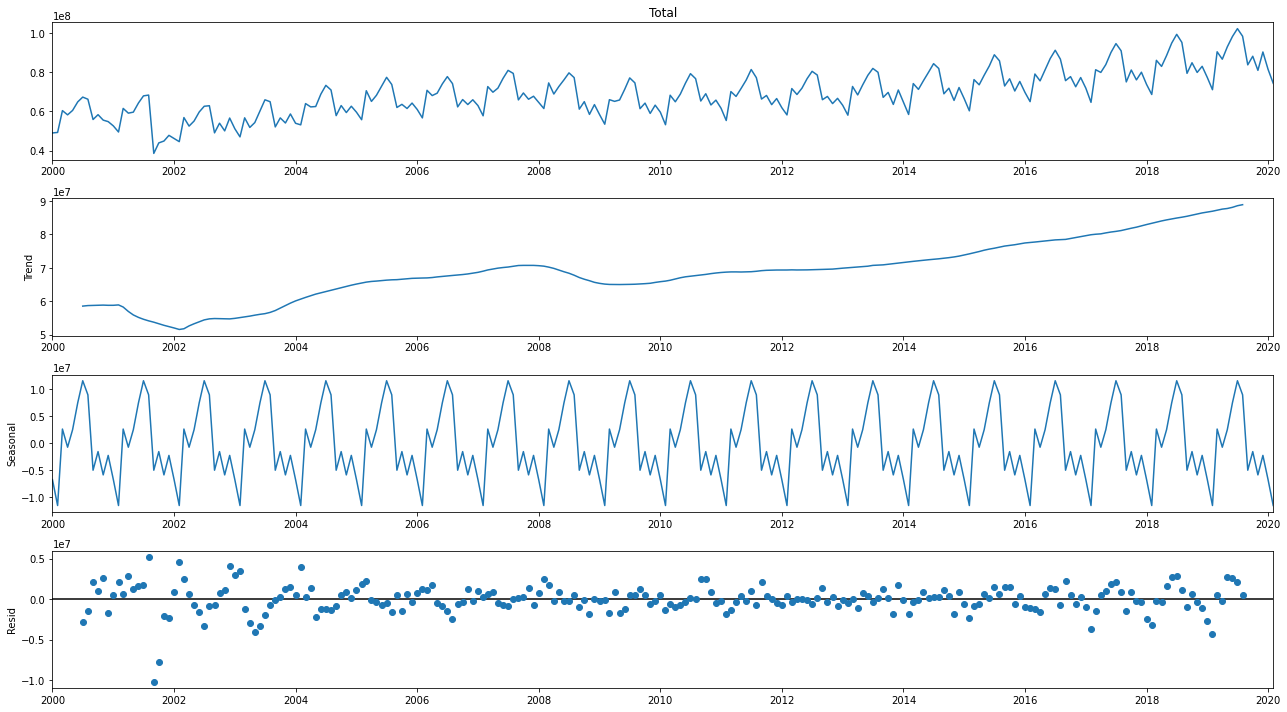

In [28]:
import statsmodels.api as sm
res = sm.tsa.seasonal_decompose(df_rpm['Total'], model='Additive')

resplot = res.plot()

Now, we validate if additive was the correct model type for this time series,

The Actual value at data point 80,

In [29]:
res.observed[80]

62345732.0

After decomposing, the value at data point 80,

In [30]:
print(res.trend[80])

67841831.29166666


In [31]:
print(res.seasonal[80])

-4951036.330555557


In [32]:
print(res.resid[80])

-545062.9611110995


Now, we add all the components and we see that the value matches to the decomposed value

In [33]:
x = res.trend[80]+res.seasonal[80]+res.resid[80]
format(x, 'f')

'62345732.000000'

Lets plot and visvualize the rooling statistics

In [34]:
def plot_rollingStatistics(timeseries):

  rolmean = timeseries.rolling(window=12).mean()
  rolstd = timeseries.rolling(window=12).std()

  plt.plot(timeseries, label='Original')
  plt.plot(rolmean, label='Rolling Mean')
  plt.plot(rolstd, label='Rolling Std')
  plt.legend(loc='best')
  plt.title('Rolling Mean & Standard Deviation')
  plt.show()

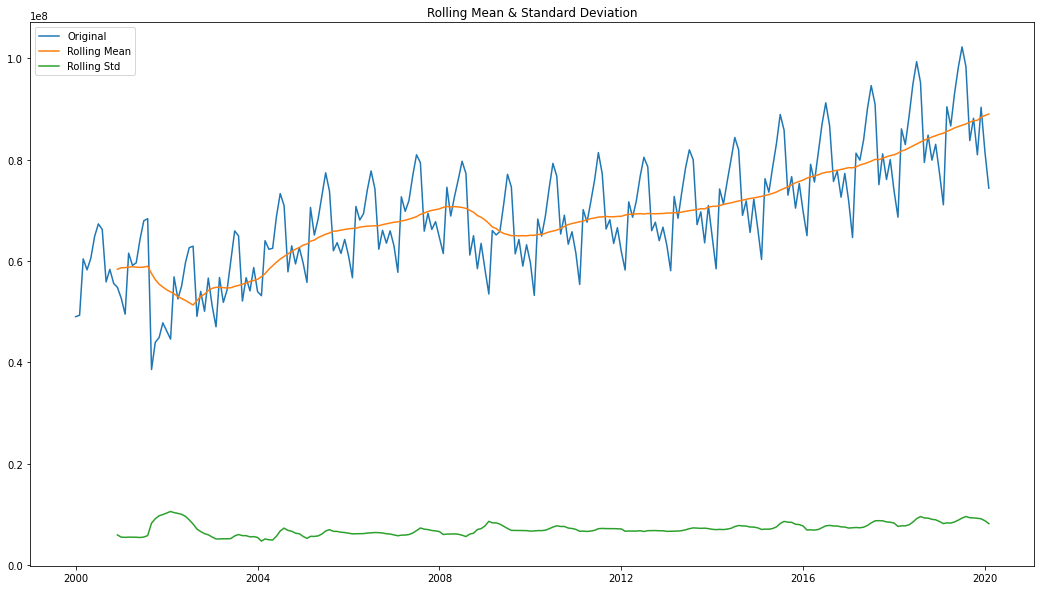

In [35]:
plot_rollingStatistics(df_rpm)

# Obervations

>Q1. How the data changes from month to month and year to year?

>1. Any trend?
>>* The visvualization for a single year indicates there is an overall increasing trend within the year.
>>* The rolling mean visvualization indicates increase in trend year on year.

>2. How fluctuated the curve is?
>>* The curve is quite fluctuated within a year as many uptrends and downtrends are observed.
>>* Also the curve fluctuation is pairal constant across years, indicating a seasonal pattern

>3. Any seasonal effects?
>>* There is dip in RPM every year in the month of Febuary; Also this month has the lowest RPM recorded within the year.
>>* There are yearly peaks in RPM every March, August, October and December; With August having the highest RPM recorded within the year.

>4. Any unusual years/months which have significantly small or large number?
>>* The Residual decomposition plot indicates, September 2001 has an unusaul dip in RPM.



# Data Prepration

Here we train the model for period 1st Jan 2000 to 1st Nov 2015 (190 months) and keep the remaining time period as test period 1st Dec 2015 to 1st Feb 2020 (12 months)

In [36]:
train_df=df_rpm[(df_rpm.index.get_level_values(0) >= '2000-01-01') & (df_rpm.index.get_level_values(0) < '2015-11-01')]

test_df=df_rpm[(df_rpm.index.get_level_values(0) >= '2015-11-01')]

In [37]:
train_df.shape

(190, 1)

In [38]:
test_df.shape

(52, 1)

# Model Building

## Holts Exponential Smoothing

In [39]:
from statsmodels.tsa.api import ExponentialSmoothing

In [40]:
holts_winter_expo_smoothing = ExponentialSmoothing(train_df, seasonal_periods=12, trend='additive', seasonal='multiplicative').fit()
holts_winter_expo_smoothing.summary()

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



Dep. Variable:,endog,No. Observations:,190
Model:,ExponentialSmoothing,SSE,642883117894063.000
Optimized:,True,AIC,5513.492
Trend:,Additive,BIC,5565.445
Seasonal:,Multiplicative,AICC,5517.492
Seasonal Periods:,12,Date:,"Thu, 16 Jul 2020"
Box-Cox:,False,Time:,10:46:13
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.6502484,alpha,True
smoothing_slope,0.0013502,beta,True


Now, we forecast the result for the test period, i.e. 52 months

In [41]:
res = holts_winter_expo_smoothing.forecast(52)

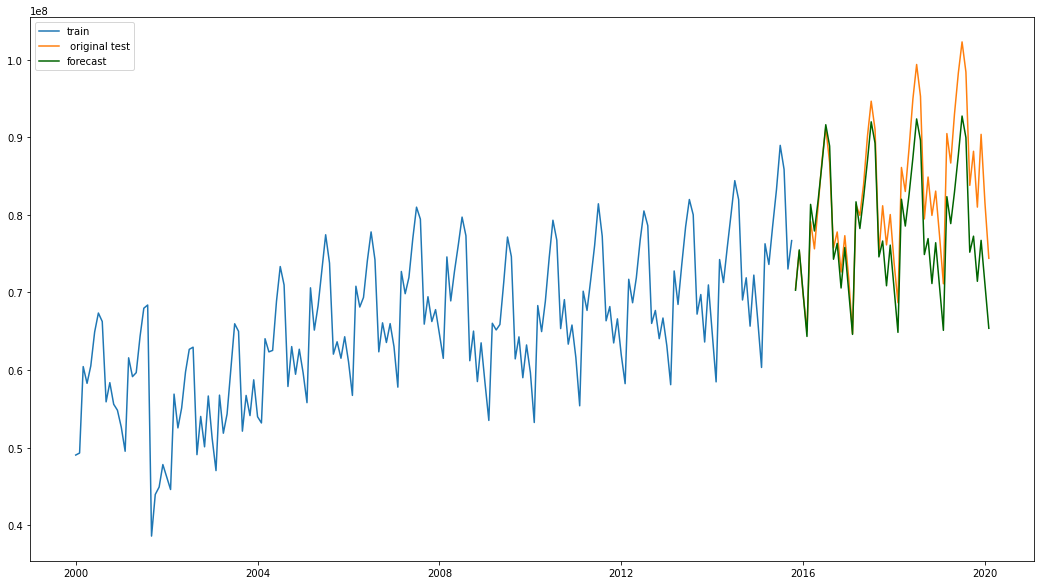

In [42]:
plt.plot(train_df['Total'], label='train')
plt.plot(test_df['Total'], label=' original test')
plt.plot(res, color='darkgreen', label='forecast')
plt.legend(loc="upper left")

## Auto Arima

Now lets try to find an optimal ARIMA model via Auto Arima and fit a model against the data.

Here we keep stepwise = False; hence a grid search is performed for all patterns

In [44]:
import pmdarima as pm

In [57]:
# model_autoarima = pm.auto_arima(df_rpm['Total'],
#                       m=12, seasonal=True,
#                       start_p=0, start_q=0, max_order=4, test='adf', error_action='ignore',
#                       suppress_warning=True,
#                       stepwise=False, trace=True)

model_autoarima = pm.auto_arima(df_rpm['Total'],
                      m=12, seasonal=True,
                      start_p=0, max_p=3, start_q=0, max_q=3, max_d=2, start_P=0, max_P=2, start_Q=0, max_Q=2, max_D=2,
                      max_order=4, test='adf', error_action='ignore',
                      suppress_warning=True,
                      stepwise=False, trace=True)

Fit ARIMA(0,1,0)x(0,1,0,12) [intercept=True]; AIC=7381.347, BIC=7388.214, Time=0.040 seconds
Fit ARIMA(0,1,0)x(0,1,1,12) [intercept=True]; AIC=7377.096, BIC=7387.398, Time=0.468 seconds
Fit ARIMA(0,1,0)x(0,1,2,12) [intercept=True]; AIC=7372.548, BIC=7386.283, Time=1.242 seconds
Fit ARIMA(0,1,0)x(1,1,0,12) [intercept=True]; AIC=7377.951, BIC=7388.253, Time=0.364 seconds
Fit ARIMA(0,1,0)x(1,1,1,12) [intercept=True]; AIC=7367.648, BIC=7381.382, Time=1.027 seconds
Fit ARIMA(0,1,0)x(1,1,2,12) [intercept=True]; AIC=7368.806, BIC=7385.974, Time=2.675 seconds
Fit ARIMA(0,1,0)x(2,1,0,12) [intercept=True]; AIC=7377.395, BIC=7391.130, Time=0.927 seconds
Fit ARIMA(0,1,0)x(2,1,1,12) [intercept=True]; AIC=7368.570, BIC=7385.739, Time=2.824 seconds
Fit ARIMA(0,1,0)x(2,1,2,12) [intercept=True]; AIC=7366.815, BIC=7387.417, Time=7.079 seconds
Fit ARIMA(0,1,1)x(0,1,0,12) [intercept=True]; AIC=7382.708, BIC=7393.009, Time=0.124 seconds
Fit ARIMA(0,1,1)x(0,1,1,12) [intercept=True]; AIC=7376.629, BIC=7390.3

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



Fit ARIMA(2,1,2)x(0,1,0,12) [intercept=True]; AIC=7389.395, BIC=7409.997, Time=2.038 seconds
Fit ARIMA(3,1,0)x(0,1,0,12) [intercept=True]; AIC=7386.191, BIC=7403.360, Time=0.202 seconds
Fit ARIMA(3,1,0)x(0,1,1,12) [intercept=True]; AIC=7378.829, BIC=7399.431, Time=0.916 seconds
Fit ARIMA(3,1,0)x(1,1,0,12) [intercept=True]; AIC=7380.347, BIC=7400.949, Time=0.760 seconds
Fit ARIMA(3,1,1)x(0,1,0,12) [intercept=True]; AIC=7387.851, BIC=7408.453, Time=0.925 seconds
Total fit time: 83.830 seconds


In [58]:
model_autoarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  242
Model:             SARIMAX(2, 1, 0)x(1, 1, [1], 12)   Log Likelihood               -3676.954
Date:                              Thu, 16 Jul 2020   AIC                           7365.908
Time:                                      11:04:32   BIC                           7386.511
Sample:                                           0   HQIC                          7374.220
                                              - 242                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1.698e+04   5.84e+04      0.291      0.771   -9.74e+04    1.31e+05
ar.L1         -0.0766      0.019     -4.003      0.000      -0.114      -0.039
ar.L2         -0.0640      0.063     -1.010      0.313      -0.188       0.060
ar.S.L12       0.5097      0.074      6.900      0.000       0.365       0.654
ma.S.L12      -0.7544      0.084     -8.959      0.000      -0.919      -0.589
sigma2      5.232e+12      0.006    8.6e+14      0.000    5.23e+12    5.23e+12
===================================================================================
Ljung-Box (Q):                       68.54   Jarque-Bera (JB):              9076.62
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.20   Skew:                            -2.92
Prob(H) (two-sided):                  0.00   Kurtosis:                        33.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.02e+29. Standard errors may be unstable.
"""

In [59]:
model_autoarima.fit(train_df['Total'])

ARIMA(maxiter=50, method='lbfgs', order=(2, 1, 0), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(1, 1, 1, 12),
      start_params=None, suppress_warnings=False, trend=None,
      with_intercept=True)

Now lets forecast for the test period. i.e. 52 months
The parameters return_conf_int returns result with a 95% (default) Confidence Interval.

In [60]:
forecast1 = model_autoarima.predict(n_periods=52, return_conf_int=True)

In [61]:
forecast_range = pd.date_range(start='2015-11-01', periods=52, freq='M')

In [62]:
forecast1_df = pd.DataFrame(forecast1[0], index = forecast_range, columns=['Prediction'])

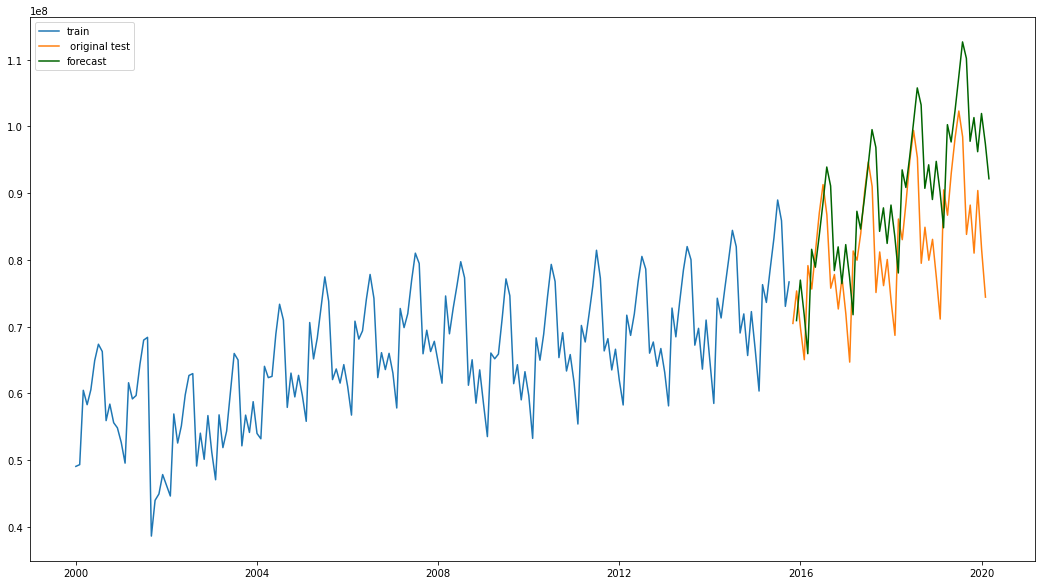

In [63]:
plt.plot(train_df['Total'], label='train')
plt.plot(test_df['Total'], label=' original test')
plt.plot(forecast1_df, color='darkgreen', label='forecast')
plt.legend(loc="upper left")

## Manual ARIMA

### Check Data Stationarity and Determine the d (For the Integration part in ARIMA)

##### Calculate and plot rolling statistics

In [66]:
def plot_rollingStatistics(timeseries):

  rolmean = timeseries.rolling(window=12).mean()
  rolstd = timeseries.rolling(window=12).std()

  plt.plot(timeseries, label='Original')
  plt.plot(rolmean, label='Rolling Mean')
  plt.plot(rolstd, label='Rolling Std')
  plt.legend(loc='best')
  plt.title('Rolling Mean & Standard Deviation')
  plt.show()

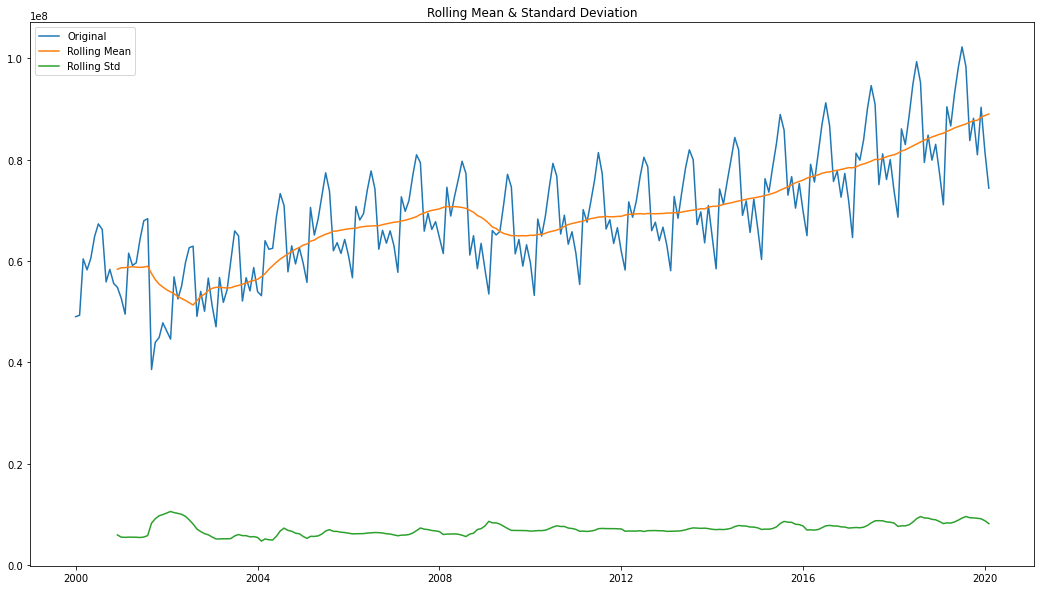

In [67]:
plot_rollingStatistics(df_rpm)

As we can see from above that the mean and standard deviation of data is not constant; hence the data is non stationary.

#### Dickey-Fuller test

> H0: series is non stationary

> H1: series is stationary

In [68]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [69]:
test_stationarity(df_rpm['Total'])

Results of Dickey-Fuller Test:
Test Statistic                   0.223216
p-value                          0.973534
#Lags Used                      13.000000
Number of Observations Used    228.000000
Critical Value (1%)             -3.459361
Critical Value (5%)             -2.874302
Critical Value (10%)            -2.573571
dtype: float64


Here, the test-statistic value is greater than the critical value at 5%; Also the p-value is greater then 0.05, hence we cannot reject the null hypopthesis and conclude that the data is non stationary.

Differencing to make data stationary and determine the d paramter in ARIMA model

In [70]:
train_diff1=train_df.diff()
train_diff1=train_diff1.dropna()

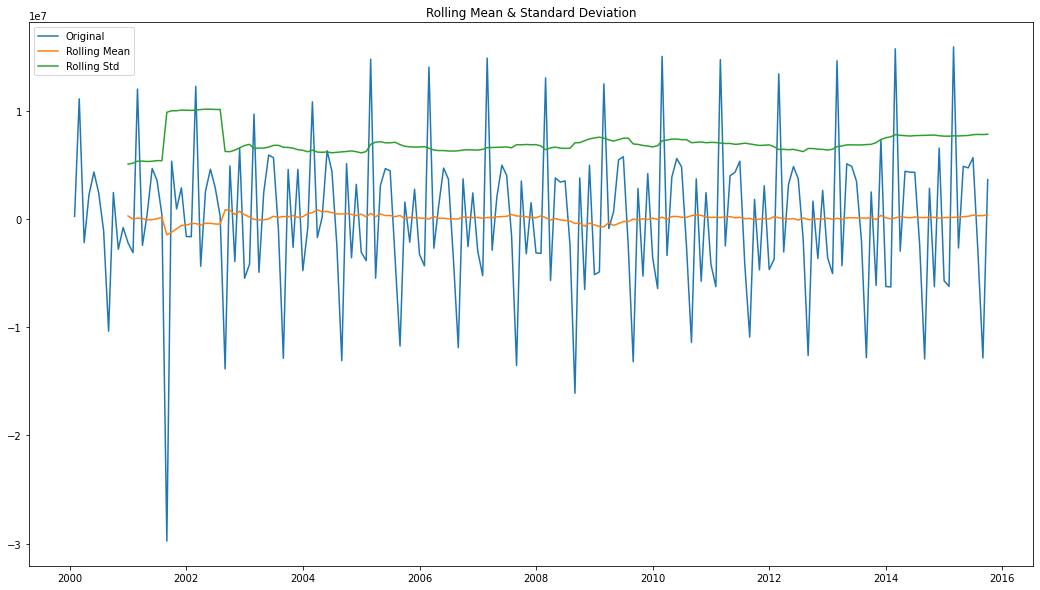

In [71]:
plot_rollingStatistics(train_diff1)

Now we can see from above that after differecing at lag 1, the mean and standard deviation of data are almost constant; hence the data seems stationary. Lets vaidate the same via ADF test.

In [72]:
test_stationarity(train_diff1['Total'])

Results of Dickey-Fuller Test:
Test Statistic                  -3.466187
p-value                          0.008899
#Lags Used                      12.000000
Number of Observations Used    176.000000
Critical Value (1%)             -3.468062
Critical Value (5%)             -2.878106
Critical Value (10%)            -2.575602
dtype: float64


Here, the test-statistic value is less than the critical value at 5%; Also the p-value is smaller then 0.05, hence we reject the null hypothesis and conclude that the data is stationary.

As the time series has become stationary after one differencing, we will set the d paramter as 1 in the ARIMA and SARIMA model

### Determine p (For AR model) and q (For MA model) parameters via PACF and ACF plots

In [73]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot

In [74]:
def plot_pacf_acf(timeseries, nlags):
  pyplot.figure(figsize=(15,10))
  pyplot.subplot(211)
  plot_acf(timeseries, ax=pyplot.gca(),lags=nlags)
  pyplot.subplot(212)
  plot_pacf(timeseries, ax=pyplot.gca(),lags=nlags)
  pyplot.show()

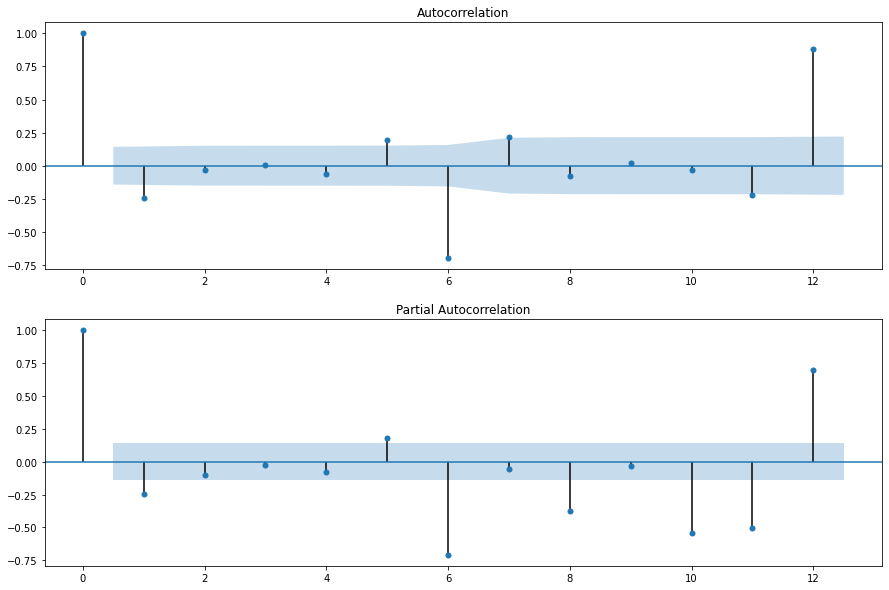

In [75]:
plot_pacf_acf(train_diff1, 12)

> From ACF plot we see a significant negative autocorrelation at lag 1 (As its outside the critical region), hence we keep the q value as 1 for the MA model

> From PACF plot we see that the partial autocorrelation at lag 1, is significant (As its ouside the critical region); Hence we keep the p value as 1 for the AR model

### Model Building

In [76]:
from statsmodels.tsa.arima_model import ARIMA

model_arima = ARIMA(train_df, order=(1,1,1))
model_arima_fit=model_arima.fit(disp=True)
print(model_arima_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Total   No. Observations:                  189
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -3221.632
Method:                       css-mle   S.D. of innovations        6092045.002
Date:                Thu, 16 Jul 2020   AIC                           6451.264
Time:                        11:07:32   BIC                           6464.231
Sample:                    02-01-2000   HQIC                          6456.517
                         - 10-01-2015                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const          1.462e+05        nan        nan        nan         nan         nan
ar.L1.D.Total     0.5615      0.059      9.564      0.000       0.446       0.677
ma.L1.D.Total    -0.9689        nan     

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:548: HessianInversionWarning:

Inverting hessian failed, no bse or cov_params available

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/arima_model.py:1490: RuntimeWarning:

invalid value encountered in sqrt

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning:

invali

### Model Forecasting and Plotting

In [77]:
forecast_arima = model_arima_fit.forecast(steps=52)

In [80]:
forecast_range = pd.date_range(start='2015-11-01', periods=52, freq='M')

In [81]:
forecast_df = pd.DataFrame(forecast_arima[0], index = forecast_range, columns=['Prediction'])

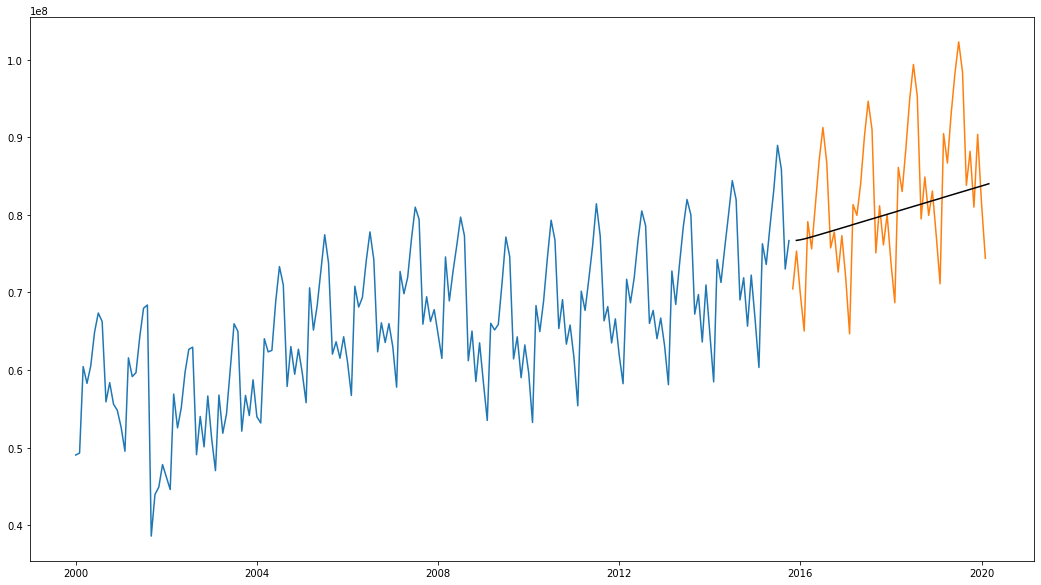

In [82]:
plt.plot(train_df, label='Train')
plt.plot(test_df, label='Test')
plt.plot(forecast_df, label='Prediction', color='black')
plt.show()

## Manual SARIMA

### Check Data Stationarity and Determine the D (For the Integration part in SARIMA)

##### Calculate and plot rolling statistics

Let's do 1st seasonal differencing i.e differencing yearly

In [83]:
train_diff12=train_df.diff(12)
train_diff12=train_diff12.dropna()

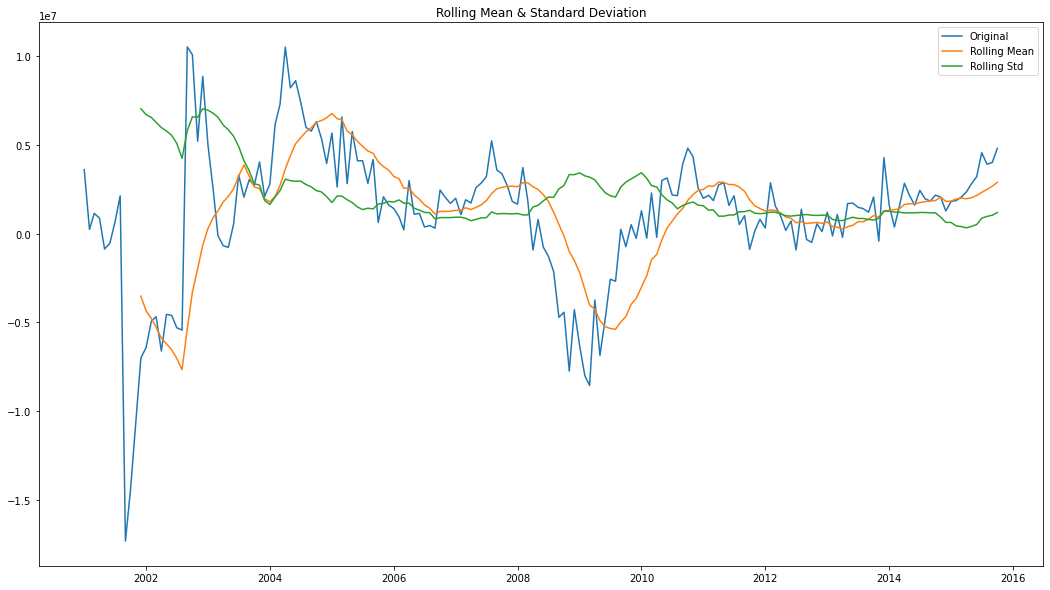

In [84]:
plot_rollingStatistics(train_diff12)

#### Dickey-Fuller test

In [85]:
test_stationarity(train_diff12['Total'])

Results of Dickey-Fuller Test:
Test Statistic                  -2.914468
p-value                          0.043691
#Lags Used                      14.000000
Number of Observations Used    163.000000
Critical Value (1%)             -3.471119
Critical Value (5%)             -2.879441
Critical Value (10%)            -2.576314
dtype: float64


Here, the test-statistic value is less than the critical value at 5%; Also the p-value is less then 0.05, hence we reject the null hypopthesis and conclude that the data is stationary after 1st differencing.

### Determine p (For AR model) and q (For MA model) parameters via PACF and ACF plots

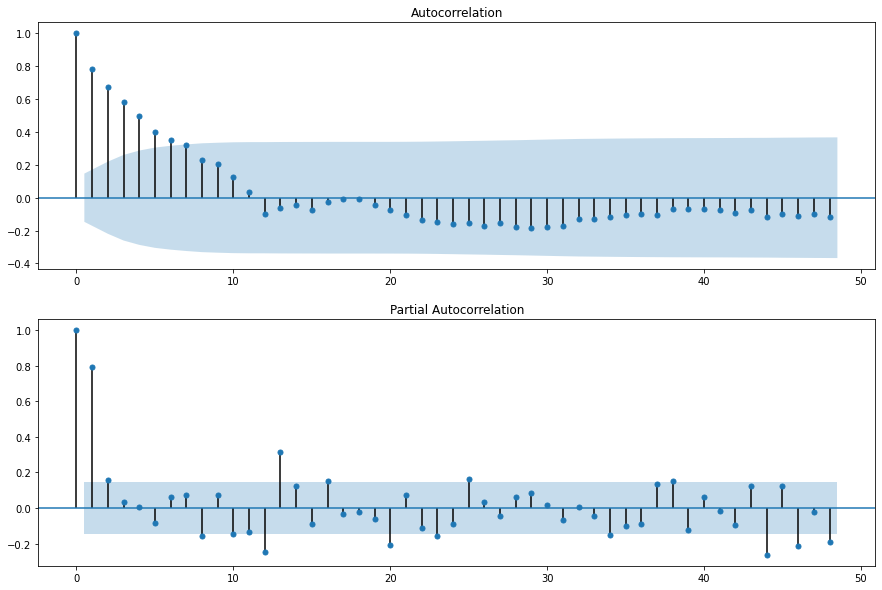

In [86]:
plot_pacf_acf(train_diff12, 48)

> From the ACF plot, we do not see a significant negative autocorrelation at lag 12 ; Post this the autocorrelation at further seasonal lags i.e. 36, 48 are inside the critical region, hence we keep the Q value as 0 for the seasonal MA model.

> From PACF plot we see that the partial autocorrelation at lag 12, is significant (As its ouside the critical region); Post this the partial autocorrelation at further seasonal lags i.e. 36, 48 are inside the critical region, Hence we keep the P value as 1 for the AR model.

### Model Building

In [87]:
model_sarima = sm.tsa.SARIMAX(train_df, order=(1,1,1), seasonal_order=(1,1,0,12))
model_sarima_fit=model_sarima.fit(disp=True)
print(model_sarima_fit.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency MS will be used.



                                      SARIMAX Results                                      
Dep. Variable:                               Total   No. Observations:                  190
Model:             SARIMAX(1, 1, 1)x(1, 1, [], 12)   Log Likelihood               -2859.792
Date:                             Thu, 16 Jul 2020   AIC                           5727.585
Time:                                     11:09:17   BIC                           5740.289
Sample:                                 01-01-2000   HQIC                          5732.737
                                      - 10-01-2015                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3601      0.997      0.361      0.718      -1.595       2.315
ma.L1         -0.4069      

### Model Forecasting and Plotting

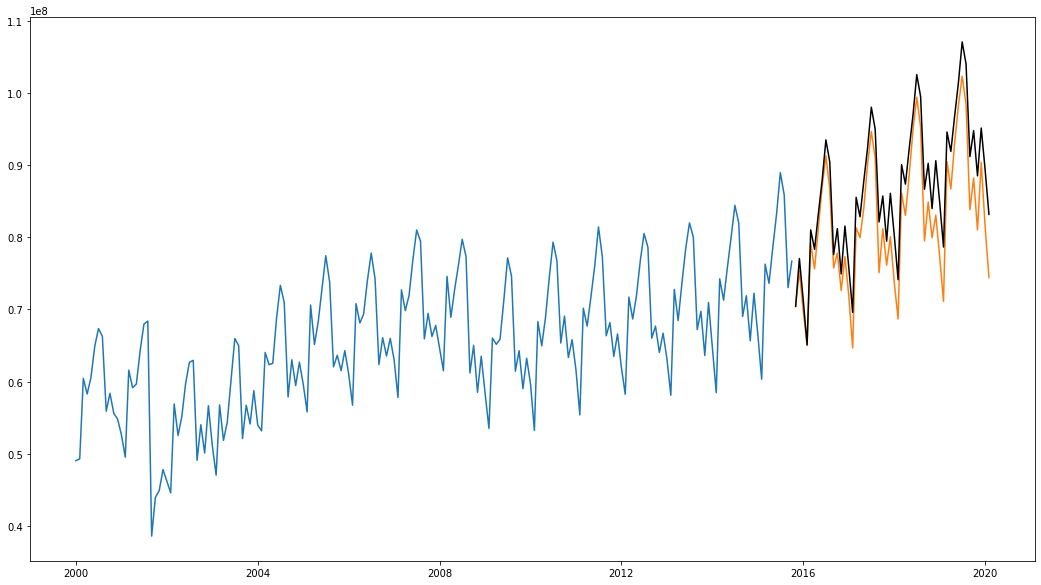

In [88]:
forecast_sarima = model_sarima_fit.forecast(steps=52)

plt.plot(train_df, label='Train')
plt.plot(test_df, label='Test')
plt.plot(forecast_sarima, label='Prediction', color='black')
plt.show()

# Model Evaluation

In [89]:
print('\n-------------------AIC Values-------------------')
print('Holts Exponential Smoothing : ', holts_winter_expo_smoothing.aic)
print('Auto ARIMA (SARIMA was selected) : ', model_autoarima.aic())
print('ARIMA : ', model_arima_fit.aic)
print('SARIMA : ', model_sarima_fit.aic)


-------------------AIC Values-------------------
Holts Exponential Smoothing :  5513.492395300894
Auto ARIMA (SARIMA was selected) :  5720.968127679592
ARIMA :  6451.26367193744
SARIMA :  5727.584894659524


In [91]:
print('\n-------------------MAE Values-------------------')
print('Holts Exponential Smoothing : ', mean_absolute_error(test_df,res[:52]))
print('Auto ARIMA (SARIMA was selected) : ', mean_absolute_error(test_df,forecast1[0][:52]))
print('ARIMA : ', mean_absolute_error(test_df,forecast_arima[0][:52]))
print('SARIMA : ', mean_absolute_error(test_df,forecast_sarima[:52])) 


-------------------MAE Values-------------------
Holts Exponential Smoothing :  4661844.622452864
Auto ARIMA (SARIMA was selected) :  7456116.111214057
ARIMA :  6815735.571349031
SARIMA :  4240725.528742197


# Conclusion

Foreacasting plots with best 2 models for test period plus additional 2 years; Firstly Holts Exponential Smoothing

In [101]:
forecast_res = holts_winter_expo_smoothing.forecast(76)

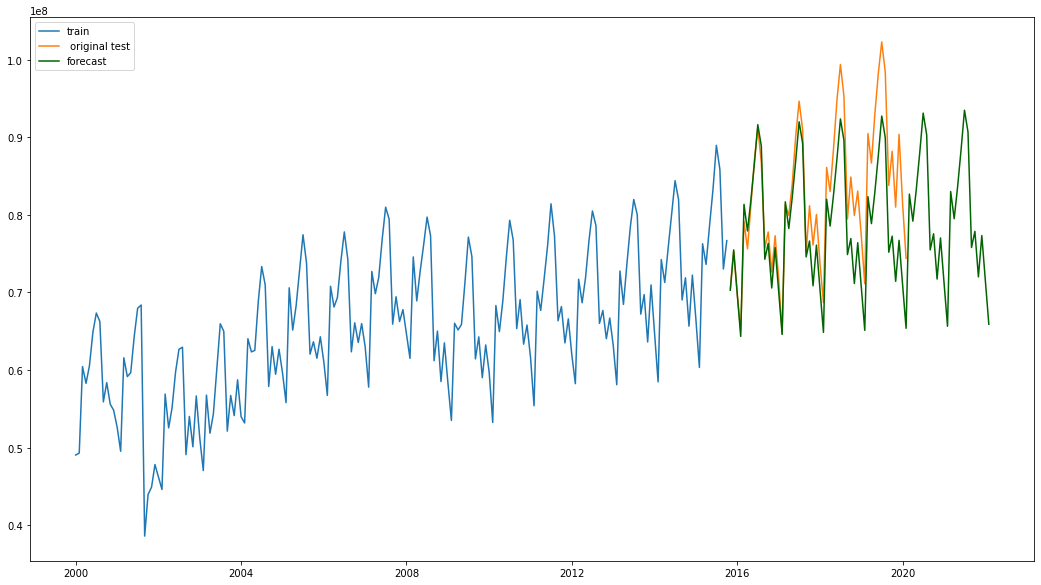

In [99]:
plt.plot(train_df['Total'], label='train')
plt.plot(test_df['Total'], label=' original test')
plt.plot(forecast_res, color='darkgreen', label='forecast')
plt.legend(loc="upper left")

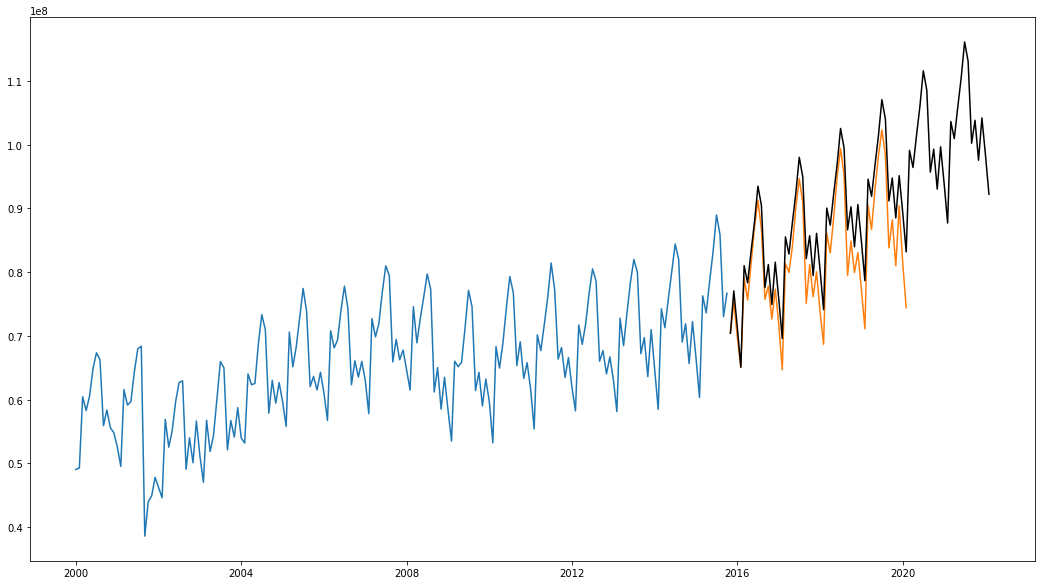

In [100]:
forecast_sarima = model_sarima_fit.forecast(steps=76)

plt.plot(train_df, label='Train')
plt.plot(test_df, label='Test')
plt.plot(forecast_sarima, label='Prediction', color='black')
plt.show()

We see that Holts Exponential Smoothing has the lowest AIC of 5512.49 but the MAE is 4661844; 

Now Manual SARIMA has slightly more AIC of 5727 (Increase of 215), but significant reduction in MAE at 4240725 (Reduction by 421119) and also forecast looks better; hence SARIMAX is the best model for the current task of forecasting RPM.